In [30]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%matplotlib inline

In [2]:
def prepare_plot():
    """
    Set up general plot aesthetics to be used for including figures in a manuscript or talk.
    These defaults are possibly too large for interactive use.
    This function should be called before `paper_plot`.
    """
    sns.set()
    # Increase font size and linewidth
    sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 5})
    sns.set_style("white")
    # Use LaTeX, setup to use Helvetica. This can be safely commented to make
    # the installation footprint of running this code smaller -- for example,
    # in Docker.
    mpl.rc('text', usetex=True)
    mpl.rcParams['text.latex.preamble'] = [
        r'\usepackage{amsmath}',
        r'\usepackage{helvet}',
        r'\usepackage[EULERGREEK]{sansmath}',
        r'\sansmath',
        r'\renewcommand{\familydefault}{\sfdefault}',
        r'\usepackage[T1]{fontenc}',
        r'\usepackage{graphicx}'
    ]

def paper_plot(fig, adjustment=0, scientific=False, save=False, filename=None,
               raster=False, label_pad=True):
    """
    Take a prepared figure and make additional adjustments for inclusion in manuscript:
    mostly tick thickness, length, and label padding, and include only the left and the bottom
    axis spines. It would be nice to force the axes to end on a major tick, but I haven't
    figured out how to do that yet.
    """
    for ax in fig.axes:
        # Increase padding
        ax.tick_params(which='major', direction='out', length=10, pad=10)
        ax.tick_params(which='minor', direction='out', length=5)
        # If plotting with pi, increase the x tick size specifically
        # ax.tick_params(axis='x', labelsize=40, pad=-10)
        # Increase tick thickness
        ax.xaxis.set_tick_params(width=2)
        ax.yaxis.set_tick_params(width=2)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        if label_pad:
            # Increase padding
            ax.xaxis.labelpad = 15
            ax.yaxis.labelpad = 15
        # Make the background color white
        facecolor = 'white'
        if facecolor is False:
            facecolor = fig.get_facecolor()
        alpha = 1
        color_with_alpha = colorConverter.to_rgba(facecolor, alpha)
        fig.patch.set_facecolor(color_with_alpha)
        # Stick the scientific notation into the axis label, instead of the
        # default position which in the corner, which really makes no sense.
        if ax.xaxis.get_scale() == 'linear':
            if scientific:
                pretty_label(ax)
            ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
            ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        elif ax.xaxis.get_scale() == 'log':
            pass
        # For scatter plots, where points get cut off
        if adjustment != 0:
            x0, x1, y0, y1 = ax.axis()
            ax.xaxis((x0 - adjustment,
                      x1 + adjustment,
                      y0,
                      y1
                     ))
        # Make axes thicker
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)
    if save:
        plt.savefig(filename + '.png', dpi=300, bbox_inches='tight')
        plt.savefig(filename + '.svg', dpi=300, bbox_inches='tight')

prepare_plot()

In [5]:
# Import Data
data = {}
data['cb8-g3'] = {}
for meth in ['mbar-block', 'ti-block']:
    data['cb8-g3'][meth] = []
    for conf in range(5):
        data['cb8-g3'][meth].append( np.genfromtxt('convg_batch/CB8-G3-'+str(conf)+'-'+meth+'.dat') )

In [62]:
# Setup plot/write function
def plot_fe(data, method, sys_name):
    
    fig = plt.figure(figsize=(6 * 1.2, 6))
    gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
    ax1 = plt.subplot(gs[0, 0])

    fe_lst = []
    sem_sum = 0.0
    f = open (sys_name+'.'+method+'.converge.dat', 'w')
    for conf in range(5):
        # 0.41 = -RTln(2) which accounts for two equiv binding sites in CB8
        fes = -1*(data[sys_name][meth][conf][:,8]) - 0.41
        sems = data[sys_name][meth][conf][:,9]
        nevals = 250*(data[sys_name][meth][conf][:,3] + data[sys_name][meth][conf][:,6])
        uc_sys_name = sys_name.upper()
        ax1.errorbar( nevals, y=fes, yerr=sems,
                     label=f'{uc_sys_name}-{conf:.0f} ({fes[-1]:6.2f} $\pm$ {sems[-1]:0.2f})',
                     elinewidth=2.0, alpha=0.5)
        fe_lst.append(fes[-1])
        sem_sum += sems[-1]
        
        f.write('{}-{}, '.format(sys_name.upper(), str(conf)))
        for i,j in zip(fes,sems):
            f.write(f'{i:0.2f}, {j:0.2f}, ')
        f.write('\n')
    f.close()

    ax1.legend(frameon=True, loc=0, framealpha=1.0, edgecolor='k')
    ax1.set_ylabel('Free energy (kcal/mol)')
    ax1.set_xlabel('Energy evaluations')
    ax1.set_title(method)
    paper_plot(fig)

    print("Mean of means:  {:.2f}".format(np.mean(np.array(fe_lst))))
    print("StdDv of means: {:.2f}".format(np.std(np.array(fe_lst))))
    print('Mean of SEMs:   {:.2f}'.format(sem_sum/5))
    

Mean of means:  -10.51
StdDv of means: 0.42
Mean of SEMs:   0.37


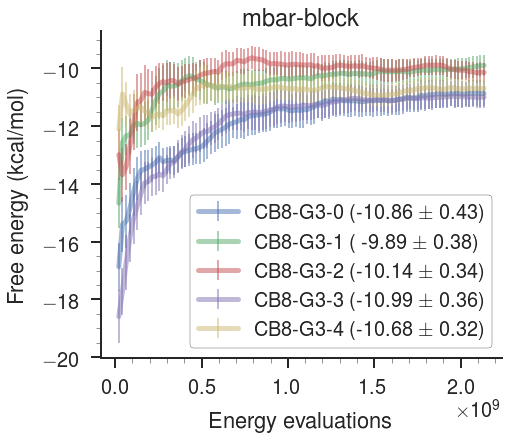

In [63]:
plot_fe(data, 'mbar-block', 'cb8-g3')

Mean of means:  -10.51
StdDv of means: 0.42
Mean of SEMs:   0.37


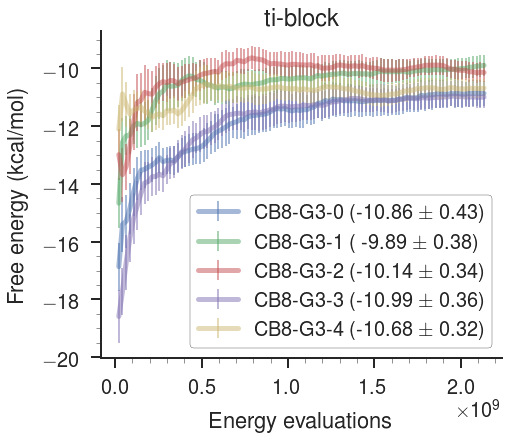

In [64]:
plot_fe(data, 'ti-block', 'cb8-g3')

In [ ]:
with open('ti-converge.dat') as f:
    for conf in range(5):
        